In [1]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
import seaborn as sns #a fancy plotting package
mpl.rcParams['figure.dpi'] = 400 #high res figures

ModuleNotFoundError: No module named 'seaborn'

## Gradient Descent to Find Optimal Parameter Values


## Exercise 16: Using Gradient Descent to Minimize a Cost Function 

We will minimize the following hypothetical cost function: y = f(x) = x^2 - 2*x

In [ ]:
def cost_function(x):
    return x*(x-2)

Visualize cost_function:

In [ ]:
X_poly = np.linspace(-3,5,81)
y_poly = cost_function(X_poly)
plt.plot(X_poly, y_poly)
plt.xlabel('Parameter value')
plt.ylabel('Cost function')

Create a function for the value of the gradient:

In [ ]:
def gradient(x):
    return 2*x - 2

Define learning rate:

In [ ]:
learning_rate = 0.75

Define starting point:

In [ ]:
x_start = 4.5

Do one step:

In [ ]:
x_next = x_start - gradient(x_start)*learning_rate

In [ ]:
x_next

Visualize step:

In [ ]:
X_poly = np.linspace(-3,5,81)
y_poly = cost_function(X_poly)
plt.plot(X_poly, y_poly)
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.plot([x_start, x_next], [cost_function(x_start), cost_function(x_next)], 'x-')
plt.legend(['Cost function', 'Gradient descent path'])

Iterate 15 times:

In [ ]:
iterations = 15
x_path = np.empty((iterations,))
x_path[0] = x_start
for iteration_count in range(1,iterations):
    x_next = x_start - gradient(x_start)*learning_rate
    x_start = x_next
    x_path[iteration_count] = x_next

In [ ]:
plt.plot(X_poly, y_poly)
plt.plot(x_path, cost_function(x_path), '-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])


## Exercise 17: Generating and Modeling Synthetic Classification Data

Generate a synthetic dataset for classification:

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
X_synthetic, y_synthetic = \
make_classification(n_samples=1000, n_features=200, n_informative=3, n_redundant=10,
                    n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None,
                    flip_y=0.01, class_sep=0.8, hypercube=True, shift=0.0, scale=1.0,
                    shuffle=True, random_state=24)

In [ ]:
X_synthetic.shape

In [ ]:
y_synthetic.shape

We have generated an almost balanced dataset close to 50/50 class balance. All the generated features have the same **scale**, taht means mean=0 and std=1. We can verify that all features are in the same range of values:

In [ ]:
for plot_index in range(4):
    plt.subplot(2,2, plot_index+1)
    plt.hist(X_synthetic[:,plot_index])
    plt.title('Histogram for feature {}'.format(plot_index+1))

Rule of 10: for every 10 ocurrences of the rarest class, 1 feature may be added. Here, since there are roughly 500 samples of the rarest class, we should have 50 features at maximum. However, the generated dataset has 200 features. This means that model is very likely to **overfit**. 

Split the data into train/test with test 20%:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
X_synthetic, y_synthetic,
test_size=0.2, random_state=24)

Do logistic regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_syn = \
LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)

In [ ]:
lr_syn.fit(X_syn_train, y_syn_train)

We are using l1 regularization (or Lasso), which adds a penalty to the cost function equal to the sum of absolute values of coefficients. Lasso regression also does **feature selection**, in that it can set coefficients to zero.

This regularization penalizes large coefficients, which are often responsible for overfitting, since a small variation of the feature may cause large changes in the outcome.

The C value is the **inverse regularization strength**. Since it multiplies the cost function, if it is very large the penalty term will have little impact (hence the name inverse).

Compute ROC AUC score for test:

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_syn_pred_proba = lr_syn.predict_proba(X_syn_test)

In [ ]:
roc_auc_score(y_syn_test, y_syn_pred_proba[:,1])

ROC AUC score for train:

In [ ]:
y_syn_train_pred_proba = lr_syn.predict_proba(X_syn_train)

In [ ]:
roc_auc_score(y_syn_train, y_syn_train_pred_proba[:,1])

The ROC AUC score is significantly higher for the training data than the test data, so that means that the model is overfitting (that is, low bias, high varianace).

## Cross Validation: Choosing the Regularization Parameter and Other Hyperparameters 

K-Fold Cross Validation divides the dataset in k parts. For example k=4, it divides in 4 parts, each part containing 25% of the dataset.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [ ]:
n_folds = 4

In [ ]:
k_folds = KFold(n_splits=n_folds, shuffle=False, random_state=1)

In [ ]:
X_syn_train.shape

In [ ]:
for train_index, test_index in k_folds.split(X_syn_train, y_syn_train):
    print(train_index.shape)
    print(test_index.shape)

Plot the train and test indexs of each fold:

In [ ]:
cmap = mpl.cm.get_cmap('tab10')

def plot_kfolds(k_folds_iterator):
    fold_counter = 0
    for train_index, test_index in k_folds_iterator.split(X_syn_train, y_syn_train):

        #Axis to hold the plot of this fold
        ax = plt.subplot(n_folds,1,fold_counter+1)

        #Background rectangle representing all samples
        n_train_samples = len(y_syn_train)
        rect = mpl.patches.Rectangle(xy=(0,0), width=n_train_samples, height=1)
        ax.add_patch(rect)

        #Plot each testing sample from this fold as a vertical line
        for this_text_ix in test_index:
            ax.plot([this_text_ix, this_text_ix], [0, 1], color=cmap(1),
                    linewidth=0.75)

        #Plot formatting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, n_train_samples)
        ax.set_ylim(0,1)
        
        #Subplot titles
        if fold_counter == 0:
            ax.text(0.26, 1.2, 'Training data,',
                    transform=ax.transAxes, backgroundcolor = cmap(0))
            ax.text(0.45, 1.2, 'testing data:',
                    transform=ax.transAxes, backgroundcolor = cmap(1))
            ax.text(0.62, 1.2, 'fold {}'.format(fold_counter+1), transform=ax.transAxes)
        else:
            ax.text(0.45, 1.2, 'Fold {}'.format(fold_counter+1), transform=ax.transAxes)

        fold_counter += 1

    plt.tight_layout()

In [ ]:
plot_kfolds(k_folds)

There's another option StratifiedKFold that ensures that the class fractions of the response variable were equal in every fold.

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=1)

In [ ]:
plot_kfolds(k_folds)

And if the data has been ordered by the date an account was created or some other logic, it may be necessary to shuffle:

In [ ]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

In [ ]:
plot_kfolds(k_folds)

##  Exercise 18: Reducing Overfitting on the Synthetic Data Classification Problem

In this exercise we will use **cross-validation** to find a good value for the **hyperparameter C** (inverse regularization strength).

1) Vary the value of C from 0.001 to 1000 using powers of 10

In [ ]:
C_exp_vals = np.linspace(3,-3, num=13)

In [ ]:
C_vals = np.float(10)**C_exp_vals

In [ ]:
C_vals

2) Define a function that takes the k_folds cross-validation splitter, the array of C values and the model object, and the features and response variable as inputs. It has to return the ROC AUCs and ROC curve data for each value of C and for each fold.

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
def cross_val_C_search(k_folds, C_vals, model, X, y):
    n_folds = k_folds.n_splits
    
    # np array to store the roc auc for each fold and each value of C
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    # list of list because we will have triples (TPR, FPR, thresholds)
    # for each fold
    # and then *len(C_vals) adds an extra dimension
    cv_test_roc = []
    for c_val_counter in range(len(C_vals)):
        # Set the C value for the model object
        model.C = C_vals[c_val_counter]
        
        # Count folds for each value of C
        fold_counter = 0
        cval_roc = []
        for train_index, test_index in k_folds.split(X,y):
            # Get the train/test data for that fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = y[train_index], y[test_index]
            
            # Train the model
            model.fit(X_cv_train, y_cv_train)
            
            # Obtain training ROC AUC score
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            # Obtain test ROC AUC score
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            # Obtain test ROC curve
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cval_roc.append(this_fold_roc)
            # Increment fold counter
            fold_counter += 1
        cv_test_roc.append(cval_roc)
        print('Done with C = {}'.format(C_vals[c_val_counter]))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

How to examine the results of cross-validation?

- Look at the results for each fold separately to see how different subsets of your data perform as test sets. This gives an idea of the range of performance you can expect from the unseen test set.

In [ ]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

In [ ]:
for this_fold in range(n_folds):
    plt.plot(C_exp_vals, cv_train_roc_auc[this_fold], '-o',
    color = cmap(this_fold), label = 'Training fold {}'.format(this_fold+1))
    
    plt.plot(C_exp_vals, cv_test_roc_auc[this_fold], '-x',
    color = cmap(this_fold), label = 'Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc=[1.1,0.2])

Analysis:
- For values lower than 10^-2 the ROC AUC drops to 0.5, which is basically saying that the model is useless. This makes sense, because for very small C Lasso regularization shrinks all the coefficients to zero.
- For values between 10^-2 and 10^-1.5 the performance of train/test is similar (good model). 
- For values higher than 10^-1.5 the training data performs significantly better than the testing data, which means that we are overfitting.

To summarize the results a common approach is to average the performance metric over the folds for each value of the hyperparameter:

In [ ]:
cv_train_roc_auc.shape

In [ ]:
plt.plot(C_exp_vals, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average training score')
plt.plot(C_exp_vals, np.mean(cv_test_roc_auc, axis=0), '-o', label='Average training score')
plt.ylabel('Mean ROC AUC score')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation scores averaged over folds')

It is clear that the best value of C is between 10^-2 and 10^-1.5, since the train and test performance is almost the same and hence there is no overfitting. Let's take C = 10^-1.5

Now we need to choose the threshold. We have to look at the ROC curves accross the different folds.

In [ ]:
len(cv_test_roc)

In [ ]:
len(cv_test_roc[0])

In [ ]:
len(cv_test_roc[0][0])

In [ ]:
len(cv_test_roc[0][0][0])

We will plot the ROC curve only for the selected C value, which is C^-1.5:

In [ ]:
best_C_val = [i for i in range(13) if C_exp_vals[i] == -1.5][0]

In [ ]:
best_C_val

In [ ]:
for this_fold in range(k_folds.n_splits):
    fpr = cv_test_roc[best_C_val][this_fold][0]
    tpr = cv_test_roc[best_C_val][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each fold at C = $10^{-1.5}$')
plt.legend()

If we want to limit FPR to 40%, then we would be able to achieve a positive rate of up to 80%.

Now the last step of the process is to train the model with train AND test data and then try it on the validation set (it has to be completely unseen, not even by the hyperparameter tuning). In our case X_syn_test, y_syn_test is our validation data.

In [ ]:
lr_syn.C = C_vals[best_C_val]

In [ ]:
lr_syn.fit(X_syn_train, y_syn_train)

In [ ]:
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)

ROC AUC score for train+test data:

In [ ]:
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

ROC AUC score for validation data:

In [ ]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)

In [ ]:
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

We can see that by using regularization, the model training and testing scores are similar, indicating that the overfitting problem has been solved. The training score is lower, because we have introduced bias into the model at the expense of having lower variance.

Finally, since we have used Lasso regularization (and it also does feature selection) let's see how many features the model is actually taking into account:

In [ ]:
sum(lr_syn.coef_[0] != 0)

Only 2 of the 200 features were selected!

In [ ]:
lr_syn.intercept_

The intercept was also regularized (makes sense since all features are scaled)

## Activity 4: Cross-Validation and Feature Engineering with the Case Study Data
 

First of all let's read the clean df and remove the features we are not going to use:

In [3]:
df = pd.read_csv('../chapter1/Chapter_1_cleaned_data.csv')

In [8]:
df.columns.values

array(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default payment next month', 'EDUCATION_CAT',
       'graduate school', 'high school', 'none', 'others', 'university'],
      dtype=object)

In [6]:
features_to_remove =  ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [9]:
features = [feat for feat in df.columns.values.tolist() if feat not in features_to_remove]

In [10]:
features

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Split the explanatory features from the response variable:

In [12]:
X = df[features[:-1]].values

In [13]:
X.shape

(26664, 17)

In [14]:
y = df[features[-1]].values

In [15]:
y.shape

(26664,)

Do train/test split using random seed of 24:

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

We are going to reserwve this testing data as the unseen test set (or validation set)

Instantiate the MinMaxScaler to scale the data:

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()

Instantiate a logistic regression model with the saga solver, L1 penalty and set max_iter to 1000. We use the saga solver because it is the appropriate one to use with L1 penalty. However, this solver is not robust to unscaled datastes, so we need to be sure to scale the data.

In [26]:
from sklearn.linear_model import LogisticRegression

In [25]:
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)

Create a Pipeline with the scaler and the logistic regression model:

In [22]:
from sklearn.pipeline import Pipeline

In [28]:
pipeline = Pipeline(steps = [('scaler', scaler), ('model', lr)])

Use the get_params and set_params methods to see how to view the parameters from each stage of the pipeline and change them.

In [30]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

Create a smaller range of C values to test with cross-validation, as these models will take longer to train and test.

In [34]:
C_vals = [100, 10, 1, 0.1, 0.01, 0.001]

Make a new version of the cross_val_C_search function called **cross_val_C_search_pipe**. Instead of the **model** argument, this function will take the **pipeline** argument.

In [32]:
from sklearn.model_selection import StratifiedKFold

In [33]:
kfold = StratifiedKFold(n_splits=4)

In [44]:
from sklearn.metrics import roc_auc_score

In [61]:
def cross_val_C_search_pipe(kfold, C_vals, pipeline, X, y):
    n_folds = kfold.n_splits  
    
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
                                
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    for C_counter in range(len(C_vals)):
        # Set C value
        pipeline.set_params(model__C = C_vals[C_counter])
        
        n_fold = 0
        for train_index, test_index in kfold.split(X, y):
                # Get the fold split
                X_cv_train, X_cv_test = X[train_index], X[test_index]
                y_cv_train, y_cv_test = y[train_index], y[test_index]
                
                # Fit
                pipeline.fit(X_cv_train, y_cv_train)
                
                # Get metrics for training
                y_cv_train_pred_proba = pipeline.predict_proba(X_cv_train)
                cv_train_roc_auc[n_fold, C_counter] = roc_auc_score(y_cv_train, y_cv_train_pred_proba[:,1])
            
                # Get metrics for testing
                y_cv_test_pred_proba = pipeline.predict_proba(X_cv_test)
                cv_test_roc_auc[n_fold, C_counter] = roc_auc_score(y_cv_test, y_cv_test_pred_proba[:,1])
            
                # Increment fold counter
                n_fold += 1   
        
        print('Done with value C = {}'.format(C_vals[C_counter]))
    
    return cv_train_roc_auc, cv_test_roc_auc            
                                 

In [62]:
cv_train_roc_auc, cv_test_roc_auc = \
cross_val_C_search_pipe(kfold, C_vals, pipeline, X_train, y_train)

Done with value C = 100
Done with value C = 10
Done with value C = 1
Done with value C = 0.1
Done with value C = 0.01
Done with value C = 0.001


Let's plot the results:

Text(0.5, 1.0, 'Cross validation on Case Study problem')

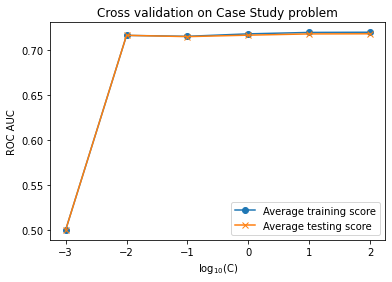

In [66]:
plt.plot(np.log10(C_vals), np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(np.log10(C_vals), np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

Look like there is no overfitting happening. In fact, we might be underfitting, considering that we have only 17 features when by the rule of 10 we could have up to 500.

### Feature Engineering

Create interaction features only:

In [67]:
from sklearn.preprocessing import PolynomialFeatures

In [69]:
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [70]:
X_interact = make_interactions.fit_transform(X)

In [71]:
X_interact.shape

(26664, 153)

Now the number of features has increased to 153. This number of features is reasonable, considering that we could have up to 500 features.

Now we repeat the same procedure as before:

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
X_interact, y, test_size=0.2, random_state=24)

In [74]:
print(X_train.shape)
print(X_test.shape)

(21331, 153)
(5333, 153)


In [77]:
cv_train_roc_auc, cv_test_roc_aucc = \
cross_val_C_search_pipe(kfold, C_vals, pipeline, X_train, y_train)

/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with value C = 100


/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with value C = 10


/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/usuari/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with value C = 1
Done with value C = 0.1
Done with value C = 0.01
Done with value C = 0.001


Text(0.5, 1.0, 'Cross validation on Case Study problem')

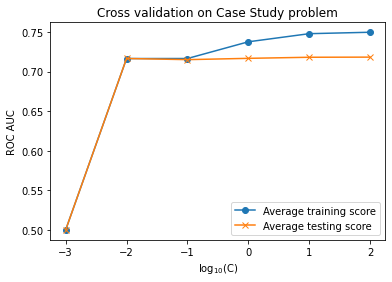

In [78]:
plt.plot(np.log10(C_vals), np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(np.log10(C_vals), np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

We have successfully solved underfitting with the new interaction features. We have also solved overfitting with regularization (taking C values from 0.01 to 0.1)